Copy this notebook (File>Save a copy in Drive), rename it using your name, and then work on your copy.
==
To send me your work: use the sharing menu (top-right of the window) to share it with timothee.m.r.bernard@gmail.com.
(I don't check this address very often, so, for questions, please use Moodle or my u-paris.fr address.)

Goal
==

We are about to design and train a neural system to perform sentiment analysis on film reviews. More precisely, the network will have to output the probability that the input review expresses a positive opinion (overall).

The system will be a bag-of-words model using GloVe embeddings. It will have to first average the embeddings of the words of the input review, and then send the result through a simple network that should output a probability.

There is a lot of code already written at the beginning of the notebook. It is important that you understand it as you will have to reuse/reproduce it for future work.

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Keep in mind all remarks given in TP 1.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Comment all the changes that you make. Any work that is not properly explained might be ignored.

Loading PyTorch is important.
==

In [1]:
# Imports PyTorch.
import torch

Downloading the dataset
==
The dataset we are going to use is the Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/).

Downloading the dataset and pre-processing it might take several minutes, so ask Colab to execute all cells while you are reading the code.

In [2]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
filename = tmp[0]

In [3]:
filename

'/tmp/tmpmswps2gz'

In [4]:
# Extracts the dataset.
import tarfile
tar = tarfile.open(filename)
tar.extractall()
tar.close()

In [5]:
import os # Useful library to read files and inspect directories.

In [6]:
# Shows which files and directories are present at the root of the file system.
for filename in os.listdir("."):
  print(filename)

.config
aclImdb
glove.6B
sample_data


In [7]:
dataset_root = "aclImdb"
# Shows which files and directories are present at the root of the dataset directory.
for filename in os.listdir(dataset_root):
  print(filename)

train
README
imdb.vocab
imdbEr.txt
test


In [8]:
# Shows several reviews.
dirname = os.path.join(dataset_root, "train", "neg") # "aclImdb/{train|test}/{neg|pos}"
for idx, filename in enumerate(os.listdir(dirname)):
  if(idx >= 5): break # Stops after the 5th file.

  print(filename)
  with open(os.path.join(dirname, filename)) as f:
    review = f.read()
    print(review)
  print()

316_1.txt
This movie is by far the worst movie ever made. If you have to create a film costarring the guy who plays Lars in heavyweights than don't make the damn film. I have to say that I could watch Leprechaun in Space 6 times before I could watch the trailer for this POS of a movie. Adam sandler should be restricted from any movie after this disgrace. Watching this movie is like a mix of listening to Cher and willingly putting your dick in a blender. Anyone with half of a brain cell will realize that this movie is not worth a dime. If I had an extra dollar and had to spend it, I'd give it to the support Lorraina Bobbitt foundation before buying this movie.

1779_1.txt
It Could Have Been A Marvelous Story Based On The Ancient Races Of Cat People, but it wasn't.<br /><br />This work could have been just that; marvelous and replete with mythological references which kept my fascination fueled. The lead characters (Charles Brady played by Brian Krause; and his mother Mary, played by Ali

Preprocessing the dataset
==

In [9]:
import nltk # Imports NLTK, an NLP library.
nltk.download('punkt') # Loads a module required for tokenization.
import collections # This library defines useful data structures.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
newline = "<br />" # The reviews sometimes contain this HTLM tag to indicate a line break.
def preprocess(text):
  text = text.replace(newline, " ") # Replaces the newline HTML tag with a space.
  tokens = nltk.word_tokenize(text); # Converts the text to a list of tokens (strings).
  tokens = [token.lower() for token in tokens] # Lowercases all tokens.

  return tokens

# Reads and pre-processes the reviews.
dataset = {"train": [], "test": []}
binary_classes = {"neg": 0, "pos": 1}
for part_name, l in dataset.items():
  for class_name, value in binary_classes.items():
    path = os.path.join(dataset_root, part_name, class_name)
    print("Processing %s..." % path, end='');
    for filename in os.listdir(path):
        with open(os.path.join(path, filename)) as f:
          review_text = f.read()
          review_tokens = preprocess(review_text)

          l.append((review_tokens, value))
    print(" done")

Processing aclImdb/train/neg... done
Processing aclImdb/train/pos... done
Processing aclImdb/test/neg... done
Processing aclImdb/test/pos... done


In [11]:
# dataset['train'], each element is a TUPLE of (list of tokenized sentence ['word1','word2'...], its class)
# for example the first example is a neg class
dataset['train'][0]

(['this',
  'movie',
  'is',
  'by',
  'far',
  'the',
  'worst',
  'movie',
  'ever',
  'made',
  '.',
  'if',
  'you',
  'have',
  'to',
  'create',
  'a',
  'film',
  'costarring',
  'the',
  'guy',
  'who',
  'plays',
  'lars',
  'in',
  'heavyweights',
  'than',
  'do',
  "n't",
  'make',
  'the',
  'damn',
  'film',
  '.',
  'i',
  'have',
  'to',
  'say',
  'that',
  'i',
  'could',
  'watch',
  'leprechaun',
  'in',
  'space',
  '6',
  'times',
  'before',
  'i',
  'could',
  'watch',
  'the',
  'trailer',
  'for',
  'this',
  'pos',
  'of',
  'a',
  'movie',
  '.',
  'adam',
  'sandler',
  'should',
  'be',
  'restricted',
  'from',
  'any',
  'movie',
  'after',
  'this',
  'disgrace',
  '.',
  'watching',
  'this',
  'movie',
  'is',
  'like',
  'a',
  'mix',
  'of',
  'listening',
  'to',
  'cher',
  'and',
  'willingly',
  'putting',
  'your',
  'dick',
  'in',
  'a',
  'blender',
  '.',
  'anyone',
  'with',
  'half',
  'of',
  'a',
  'brain',
  'cell',
  'will',
  'reali

In [12]:
# Splits the train set into a proper train set and a development/validation set.
# 'dataset["train"]' happens to be a list composed of a certain number of negative examples followed by the same number of positive examples.
# We are going to use 3/4 of the original train set as our actual train set, and 1/4 as our development set.
# We want to keep balanced train and development sets, i.e. for both, half of the reviews should be positive and half should be negative.
if("dev" in dataset): print("This should only be run once.")
else:
  dev_set_half_size = int((len(dataset["train"]) / 4) / 2) # Half of a quarter of the training set size.
  dataset["dev"] = dataset["train"][:dev_set_half_size] + dataset["train"][-dev_set_half_size:] # Takes some negative examples at the beginning and some positive ones at the end.
  dataset["train"] = dataset["train"][dev_set_half_size:-dev_set_half_size] # Removes the examples used for the development set.

  for (part, data) in dataset.items():
    class_counts = collections.defaultdict(int)
    for (_, p) in data: class_counts[p] += 1
    print(f"{part}: {class_counts}")
  print("Train set split into train/dev.")

train: defaultdict(<class 'int'>, {0: 9375, 1: 9375})
test: defaultdict(<class 'int'>, {0: 12500, 1: 12500})
dev: defaultdict(<class 'int'>, {0: 3125, 1: 3125})
Train set split into train/dev.


Loading the word embeddings
==
We are going to use GloVe embeddings.

All word forms with a frequency below a given threshold are going to be considered unknown forms.

In [13]:
# Computes the frequency of all word forms in the train set.
word_counts = collections.defaultdict(int)

for tokens, _ in dataset["train"]:
  for token in tokens: word_counts[token] += 1

print(word_counts)

defaultdict(<class 'int'>, {'this': 56864, 'was': 37969, 'not': 23771, 'enjoyable': 647, 'to': 101266, 'watch': 5162, '.': 204956, 'frank': 351, 'puts': 295, 'all': 17501, 'his': 21951, 'dreams': 314, 'on': 25224, 'the': 250630, 'back': 3614, 'burner': 5, 'and': 122161, 'gets': 2390, 'a': 121700, 'normal': 327, '(': 26675, 'boring': 1369, '!': 18277, ')': 27202, 'job': 1693, 'just': 13210, 'so': 15112, 'stepson': 4, 'can': 9123, 'go': 3824, 'film': 29530, 'school': 1168, ',': 206473, 'but': 31962, 'decides': 421, 'that': 55027, 'he': 22398, "'ll": 2148, 'make': 5830, 'humiliating': 21, 'documentary': 649, 'about': 12991, 'man': 4206, 'instead': 1628, 'filmmaker': 241, 'should': 4006, 'point': 2340, 'camera': 1204, 'simply': 1485, 'shoot': 282, 'manipulate': 28, 'comment': 484, 'with': 33034, 'snide': 8, 'captions': 6, 'bitterness': 15, 'resentment': 17, 'of': 108758, 'towards': 475, 'stepfather': 24, 'is': 82973, 'obvious': 782, 'sad': 715, 'goal': 104, 'seems': 2650, 'be': 20043, 'app

In [14]:
# Builds a vocabulary containing only those words present in the train set with a frequency above a given threshold.
count_threshold = 4;
vocabulary = set()
for word, count in word_counts.items():
    if(count > count_threshold): vocabulary.add(word)

print(vocabulary)
print(len(vocabulary))

{'digger', 'furst', 'onscreen', 'discovery', "'twist", 'injuries', 'leisen', 'prc', 'condescending', 'dependency', 'insecurities', 'warm', 'paedophile', 'join', 'synonymous', 'puff', 'parodying', 'superdome', 'akshaye', 'mock', 'sixteen', 'underscore', 'wussy', 'truck', 'flag', 'rehab', 'hooked', 'makers', 'track', '1936', 'questions', 'kine', 'pereira', 'escape', 'apologies', 'regent', 'steamer', 'estonia', 'sessions', 'wallpaper', 'sica', 'wurb', 'buccaneer', 'unconvincing', 'brace', 'straight-to-video', 'lucien', 'riots', 'context', 'bride-to-be', 'razzie', 'necklace', 'pepper', 'handguns', 'demi', 'karate', 'bettered', 'synchronization', 'ingénue', 'tootsie', 'germs', 'yin', 'aesthetics', 'coffy', 'archibald', 'deathly', 'bug', 'squad', 'recurring', 'workaholic', 'usual', 'favorable', 'cinemas', 'replied', 'pound', 'comically', 'dot', 'dimitri', 'hey', 'doo', 'howie', 'shanao', 'hairdresser', 'sirtis', 'mystery/thriller', 'call', 'amazement', 'joined', 'bourbon', 'bliss', 'dullness

In [15]:
import zipfile
import numpy as np

In [16]:
# # Returns a dictionary {word[String]: id[Integer]} and a list of Numpy arrays.
# # `data_path` is the path of the directory containing the GloVe files (if None, 'glove.6B' is used)
# # `max_size` is the number of word embeddings read (starting from the most frequent; in the GloVe files, the words are sorted)
# # If `vocabulary` is specified (as a set of strings, or a dictionary from strings to integers), the output vocabulary contains the intersection of `vocabulary` and the words with a defined embedding. Otherwise, all words with a defined embedding are used.
# def get_glove(dim=50, vocabulary=None, max_size=-1, data_path=None):
#   dimensions = set([50, 100, 200, 300]) # Available dimensions for GloVe 6B
#   fallback_url = 'http://nlp.stanford.edu/data/glove.6B.zip' # (Remember that in GloVe 6B, words are lowercased.)

#   assert (dim in dimensions), (f'Unavailable GloVe 6B dimension: {dim}.')

#   if(data_path is None): data_path = 'glove.6B'

#   # Checks that the data is here, otherwise downloads it.
#   if(not os.path.isdir(data_path)):
#     #print('Directory "%s" does not exist. Creation.' % data_path)
#     os.makedirs(data_path)

#   glove_weights_file_path = os.path.join(data_path, f'glove.6B.{dim}d.txt')

#   if(not os.path.isfile(glove_weights_file_path)):
#     local_zip_file_path = os.path.join(data_path, os.path.basename(fallback_url))

#     if(not os.path.isfile(local_zip_file_path)):
#       print(f'Retreiving GloVe embeddings from {fallback_url}.')
#       urllib.request.urlretrieve(fallback_url, local_zip_file_path)

#     with zipfile.ZipFile(local_zip_file_path, 'r') as z:
#       print(f'Extracting GloVe embeddings from {local_zip_file_path}.')
#       z.extractall(path=data_path)

#   assert os.path.isfile(glove_weights_file_path), (f"GloVe file {glove_weights_file_path} not found.")

#   # Reads GloVe data.
#   print('Reading GloVe embeddings.')
#   new_vocabulary = {} # A dictionary {word[String]: id[Integer]}
#   embeddings = [] # The list of embeddings (Numpy arrays)
#   with open(glove_weights_file_path, 'r') as f:
#     for line in f: # Each line consist of the word followed by a space and all of the coefficients of the vector separated by a space.
#       values = line.split()

#       # Here, I'm trying to detect where on the line the word ends and where the vector begins. As in some version(s) of GloVe words can contain spaces, this is not entirely trivial.
#       vector_part = ' '.join(values[-dim:])
#       x = line.find(vector_part)
#       word = line[:(x - 1)]

#       if((vocabulary is not None) and (not word in vocabulary)): # If a vocabulary was specified and if the word is not it…
#         continue # …this word is skipped.

#       new_vocabulary[word] = len(new_vocabulary)
#       embedding = np.asarray(values[-dim:], dtype=np.float32)
#       embeddings.append(embedding)

#       if(len(new_vocabulary) == max_size): break
#   print('(GloVe embeddings loaded.)')
#   print()

#   return (new_vocabulary, embeddings)
#   # new_vocabulary is a dict, {word:id}, a projection from each word to its id
#   # embedding: np array list, dim=50, order is the same as the new_vocabulary's id

# Returns a dictionary {word[String]: id[Integer]} and a list of Numpy arrays.
# `data_path` is the path of the directory containing the GloVe files (if None, 'glove.6B' is used)
# `max_size` is the number of word embeddings read (starting from the most frequent; in the GloVe files, the words are sorted)
# If `vocabulary` is specified (as a set of strings, or a dictionary from strings to integers), the output vocabulary contains the intersection of `vocabulary` and the words with a defined embedding. Otherwise, all words with a defined embedding are used.
def get_glove(dim=50, vocabulary=None, max_size=-1, data_path=None):
  dimensions = set([50, 100, 200, 300]) # Available dimensions for GloVe 6B
  fallback_url = 'http://nlp.stanford.edu/data/glove.6B.zip' # (Remember that in GloVe 6B, words are lowercased.)

  assert (dim in dimensions), (f'Unavailable GloVe 6B dimension: {dim}.')

  if(data_path is None): data_path = 'glove.6B'

  # Checks that the data is here, otherwise downloads it.
  if(not os.path.isdir(data_path)):
    #print('Directory "%s" does not exist. Creation.' % data_path)
    os.makedirs(data_path)

  glove_weights_file_path = os.path.join(data_path, f'glove.6B.{dim}d.txt')

  if(not os.path.isfile(glove_weights_file_path)):
    local_zip_file_path = os.path.join(data_path, os.path.basename(fallback_url))

    if(not os.path.isfile(local_zip_file_path)):
      print(f'Retreiving GloVe embeddings from {fallback_url}.')
      urllib.request.urlretrieve(fallback_url, local_zip_file_path)

    with zipfile.ZipFile(local_zip_file_path, 'r') as z:
      print(f'Extracting GloVe embeddings from {local_zip_file_path}.')
      z.extractall(path=data_path)

  assert os.path.isfile(glove_weights_file_path), (f"GloVe file {glove_weights_file_path} not found.")

  # Reads GloVe data.
  print('Reading GloVe embeddings.')
  new_vocabulary = {} # A dictionary {word[String]: id[Integer]}
  embeddings = [] # The list of embeddings (Numpy arrays)
  with open(glove_weights_file_path, 'r') as f:
    for line in f: # Each line consist of the word followed by a space and all of the coefficients of the vector separated by a space.
      values = line.split()

      # Here, I'm trying to detect where on the line the word ends and where the vector begins. As in some version(s) of GloVe words can contain spaces, this is not entirely trivial.
      vector_part = ' '.join(values[-dim:])
    #   x = line.find(vector_part)
    #   word = line[:(x - 1)]
      # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      # reduce the time complexity, because find() in O(n*m) but len() in O(1)
      word = line[:len(line) - len(vector_part) - 2]

      if((vocabulary is not None) and (not word in vocabulary)): # If a vocabulary was specified and if the word is not it…
        continue # …this word is skipped.

      new_vocabulary[word] = len(new_vocabulary)
      embedding = np.asarray(values[-dim:], dtype=np.float32)
      embeddings.append(embedding)

      if(len(new_vocabulary) == max_size): break
  print('(GloVe embeddings loaded.)')
  print()

  return (new_vocabulary, embeddings)

In [17]:
%%time
(new_vocabulary, embeddings) = get_glove(dim=50, vocabulary=vocabulary)

Reading GloVe embeddings.
(GloVe embeddings loaded.)

CPU times: user 2.33 s, sys: 127 ms, total: 2.46 s
Wall time: 2.48 s


In [18]:
print(len(new_vocabulary)) # Shows the size of the vocabulary.
print(new_vocabulary) # Shows each word and its id.

25492
{'the': 0, ',': 1, '.': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'a': 7, "'s": 8, 'for': 9, '-': 10, 'that': 11, 'on': 12, 'is': 13, 'was': 14, 'said': 15, 'with': 16, 'he': 17, 'as': 18, 'it': 19, 'by': 20, 'at': 21, '(': 22, ')': 23, 'from': 24, 'his': 25, "''": 26, '``': 27, 'an': 28, 'be': 29, 'has': 30, 'are': 31, 'have': 32, 'but': 33, 'were': 34, 'not': 35, 'this': 36, 'who': 37, 'they': 38, 'had': 39, 'i': 40, 'which': 41, 'will': 42, 'their': 43, ':': 44, 'or': 45, 'its': 46, 'one': 47, 'after': 48, 'new': 49, 'been': 50, 'also': 51, 'we': 52, 'would': 53, 'two': 54, 'more': 55, "'": 56, 'first': 57, 'about': 58, 'up': 59, 'when': 60, 'year': 61, 'there': 62, 'all': 63, '--': 64, 'out': 65, 'she': 66, 'other': 67, 'people': 68, "n't": 69, 'her': 70, 'percent': 71, 'than': 72, 'over': 73, 'into': 74, 'last': 75, 'some': 76, 'government': 77, 'time': 78, '$': 79, 'you': 80, 'years': 81, 'if': 82, 'no': 83, 'world': 84, 'can': 85, 'three': 86, 'do': 87, ';': 88, 'president':

In [19]:
# check the a word embedding
word = 'test'
if word in new_vocabulary:
  word_id = new_vocabulary[word]
  word_embedding = embeddings[word_id]
  print(f"The embedding of the word '{word}' has shape {word_embedding.shape}.")
  print(word_embedding)
else:
  print(f"The word '{word}' is not in the vocabulary.")

The embedding of the word 'test' has shape (50,).
[ 0.13175  -0.25517  -0.067915  0.26193  -0.26155   0.23569   0.13077
 -0.011801  1.7659    0.20781   0.26198  -0.16428  -0.84642   0.020094
  0.070176  0.39778   0.15278  -0.20213  -1.6184   -0.54327  -0.17856
  0.53894   0.49868  -0.10171   0.66265  -1.7051    0.057193 -0.32405
 -0.66835   0.26654   2.842     0.26844  -0.59537  -0.5004    1.5199
  0.039641  1.6659    0.99758  -0.5597   -0.70493  -0.0309   -0.28302
 -0.13564   0.6429    0.41491   1.2362    0.76587   0.97798   0.58507
 -0.30176 ]


### XU: torch.stack
1. torch.stack 可以保留两个信息，属于扩张再拼接
 a. 序列
 b. tensor矩阵
2. torch.stack(inputs,dim=?) -> tensor
 a. 需要输入的内部张量元素shape 相同 (glove 保证了所有的dim都一致，这里是50）



In [20]:
embedding_test = torch.tensor(embeddings[new_vocabulary['test']])
embedding_train = torch.tensor(embeddings[new_vocabulary['train']])

stacked_embeddings_dim0 = torch.stack((embedding_test,embedding_train),dim=0)

print(stacked_embeddings_dim0.shape)
# 当我们设定dim = 0 的时候，他会吧两个embedding 叠起来，也就是本来是(50,)的line vector, 现在是一个[2,50] 的矩阵了
stacked_embeddings_dim1 = torch.stack((embedding_test,embedding_train),dim=1)
print(stacked_embeddings_dim1.shape)
# dim 大小要大于等于0 小于len(stacked_embedding)
print(len(stacked_embeddings_dim0))

torch.Size([2, 50])
torch.Size([50, 2])
2


Batch generator
==

In [21]:
# Defines a class of objects that produce batches from the dataset.
class BatchGenerator:
  def __init__(self, dataset, vocabulary):
    self.dataset = dataset
    for part in self.dataset.values(): # Shuffles the dataset so that positive and negative examples are mixed.
      np.random.shuffle(part)

    self.vocabulary = vocabulary # Dictonary {word[String]: id[Integer]}
    self.unknown_word_id = len(vocabulary) # Id for unknown forms
    self.padding_idx = len(vocabulary) + 1 # Not all reviews of a given batch will have the same length. We will "pad" shorter reviews with a special token id so that the batch can be represented by a matrix.
#当padding_idx为vocab_len+1 我们就可以把所有的未知单词映射到这个id上，pad也可以映射到这里
  def length(self, data_type='train'):
    return len(self.dataset[data_type]) # 参考dataloader 中的len，我们需要知道还剩下多少数据（train mode）

  # Returns a random batch.
  # Batches are output as a triples (word_ids, polarity, texts).
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def get_batch(self, batch_size, data_type, subset=None):
    """
    每次调用都会随机选择batch_size eg30 个instances
    Max_i : 是batch size, 如果subset没有设定的话，否则是subset大小
    instance_ids: 有放回抽样，也可以理解替换采样
    也就是说 get batch 可能会得到相同的句子
    """
    data = self.dataset[data_type] # selects the relevant portion of the dataset.

    max_i = len(data) if(subset is None) else min(subset, len(data)) # 这里是决定我们的batch size， 一个batch包含几个数据，我们设定了subset，这个参数可以更好的帮助我们的debug
    instance_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some instance ids.
    ## 返回的是我们选取的句子ID

    return self._ids_to_batch(data, instance_ids)

  def _ids_to_batch(self, data, instance_ids):
    """
    这个方法是用来将实例ID转化为batch 数据
    一个id 对应一个data = ([list of word, polarity])
    如果instance_ids有10个，那么会返回10个tuple
    """
    word_ids = [] # Will be a list of lists of word ids (Integer) -> [['tok1','tok2'....],['tok1','tok2'...]]
    polarity = [] # Will be a list of review polarities (Boolean) -> 0/1
    texts = [] # Will be a list of lists of words (String)
    for instance_id in instance_ids:
      text, p = data[instance_id]

      word_ids.append([self.vocabulary.get(w, self.unknown_word_id) for w in text]) # 查找vocabulary 对应的Key，如果没有则找unk 的key
      polarity.append(p)
      texts.append(text)

    # Padding
    self.pad(word_ids) # 调用了Pad 方法，这是为了让所有的数据都一个len

    word_ids = torch.tensor(word_ids, dtype=torch.long) # Conversion to a tensor
    polarity = torch.tensor(polarity, dtype=torch.bool) # Conversion to a tensor

    return (word_ids, polarity, texts) # We don't really need `texts` but it might be useful to debug the system.
    # word_ids : list(tensor[long])
    # polarity : list(tensor[bool])

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, word_ids):
    max_length = max([len(s) for s in word_ids]) # word_ids 是一个List of list, 其中这个s 代表每个sentence, 我们找到最长的sentence长度让其做我们的pad长度
    for s in word_ids: s.extend([self.padding_idx] * (max_length - len(s)))# 根据句子长度来动态添加所需要的[pad_id]

  # Returns a generator of batches for a full epoch.
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def all_batches(self, batch_size, data_type="train", subset=None):
    """
    根据选定的data type  选定我们针对哪个subsection 获得batch
    max_i : 解释同get_batch


    """
    data = self.dataset[data_type]

    max_i = len(data) if(subset is None) else min(subset, len(data))

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      # 第一次是i =0 ，会生成batch_size个数据，假如说batch_size为30 instance id 会有（0，30） -> 31个数字，拿到30个数据 0~29
      # 第二次是 i = 30 会生成batch_size个数据，batch_size为30,那么instance ids 是(30,60) 会拿到30个数据 30~59
      # 第三次是 i = 60, instance ids 是(60,90) 会拿到 60~89 的数据 i = 90
      # 第四次是 i= 90+30 = 120 退出循环，但是因为依旧没有到max_i, 所以继续下面的if 循环
      instance_ids = np.arange(i, (i + batch_size)) # np.arange是[),半开不包括 例如np.arange(1,5) -> [1,2,3,4] [nparray]
      yield self._ids_to_batch(data, instance_ids)
      i += batch_size

    # Possibly generates the last (not full) batch.
    if(i < max_i):
      # 第五次, i = 90, instance_ids (90,100) -> 拿到90~99 的十个数据 ，生成器结束，退出if
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(data, instance_ids)

  # Turns a list of arbitrary pre-processed texts into a batch.
  # This function will be used to infer the polarity of a unannotated review.
  def turn_into_batch(self, texts):
    word_ids = [[self.vocabulary.get(w, self.unknown_word_id) for w in text] for text in texts]
    self.pad(word_ids)
    return torch.tensor(word_ids, dtype=torch.long)

batch_generator = BatchGenerator(dataset=dataset, vocabulary=new_vocabulary)
print(batch_generator.length('train')) # Prints the number of instance in the train set.

18750


In [22]:
tmp = batch_generator.get_batch(3, data_type="train")
print(tmp[0].shape) # Prints the matrix of token ids. This matrix is what will be fed as input to the model (defined below).
print(tmp[1]) # Prints the vector of polarities. This vector will be used to compute the loss when training the model.
print(tmp[2]) # Prints the list of reviews.

torch.Size([3, 196])
tensor([False, False,  True])
[['``', 'darkness', "''", 'was', 'entertaining', 'to', 'some', 'degree', ',', 'but', 'it', 'never', 'seemed', 'to', 'have', 'a', 'plot', ',', 'lacking', 'one', 'more', 'so', 'than', 'other', 'films', 'that', 'have', 'been', 'accused', 'of', 'this', 'detriment', ';', 'i.e', '.', '``', 'bad', 'taste', "''", '.', 'it', 'started', 'off', 'really', 'good', ',', 'with', 'a', 'man', 'running', 'from', 'something', '.', 'it', 'was', 'very', 'creepy', 'for', 'these', 'first', 'few', 'minutes', ',', 'but', 'after', 'a', 'time', 'the', 'film', 'just', 'became', 'entertaining', 'on', 'the', 'level', 'of', 'gore', ',', 'which', 'was', 'hard', 'to', 'make', 'out', 'at', 'some', 'points', 'due', 'to', 'poor', 'lighting', 'and', 'horrible', 'recording', 'quality', 'anyway', '.', 'the', 'film', 'was', 'hard', 'to', 'believe', 'because', 'of', 'the', 'juvenile', 'acting', ',', 'which', 'most', 'of', 'the', 'time', ',', 'seemed', 'like', 'some', 'friends

In [23]:
#每次call get_batch会拿到batch_size的数据，是随机的,但是get batch是我们想拿到示例用的，在生成整个batch的时候我们并没有用get batch
# get batch 会通过_ids_to_batchs转化为tuple(word_idx,polarity,sent)
tmp[0].shape # 3个句子， 每个有327个tok (including padding tok)

torch.Size([3, 196])

In [24]:
len(list(batch_generator.all_batches(batch_size=3, data_type="train"))) # Number of batches in the training set for batches of size 3

6250

The model
==
Here you have to complete the implementation of the model.
This model is expected to accept as input a matrix of token ids (in which each line represents a review) and to output a vector (in which each value represents the probability that the corresponding review is positive).

Please, **pay attention to all comments**.
They contain useful information.

You might wonder what the `.to` method of tensors is for.
To execute the neural network faster, we will run it on a GPU instead of a CPU.
To do so, data and parameters should be sent on the GPU, which is done by using the `.to` method.
This is possible if the parameters of the notebook allow it (i.e. if Edit/Notebook Settings/Hardware Accelerator is "GPU"), which should be the case.
If you implement things correctly, you should not need to add any call to the `.to` method here (and only one or two later during the training process).

For your system to be efficient, you should **never loop over a tensor** whenever it is possible to do otherwise.

In [25]:
# Input : matrix of token_id , each row is an example
# output: a vector, each value represent the probability that the corresponding row is positive
## if input [3,325] -> output [3]

class SentimentClassifier(torch.nn.Module):
  # embeddings: list of Numpy arrays
  # hidden_sizes: list of the size (Integer) of each hidden layer; there may be 0 or more hidden layers
  # freeze_embeddings: boolean; indicates whether the embeddings should be frozen (i.e., not fine-tuned) during training
  # device: string; indicates on which type of hardware PyTorch computation should be run
  def __init__(self, embeddings, hidden_sizes, freeze_embeddings=True, device='cuda'):
    embeddings = list(embeddings) # Creates a copy of the list of embeddings, so we can add or remove entries without affecting the original list.
    super().__init__() # Calls the constructor of the parent class. Usually, this is necessary when creating a custom module.

    # Here you have to (i) define a vector for unknown forms (the average of actual word embeddings) and a vector for the padding token (full of 0·s)
    #and (ii) define an embedding layer 'self.embeddings' using torch.nn.Embedding.from_pretrained and without forgetting to use the 'freeze' and 'padding_idx' arguments (this last argument is used to keep the padding embedding at 0 even when fine-tuning the other embeddings).
    # The following error (if you get it) indicates that the value provided for 'padding_idx' does not correspond to any embedding in the matrix that you provide (in other words, the matrix is likely to be incomplete): "Padding_idx must be within num_embeddings".
    #################
    embeddings_tensor = torch.tensor(np.array(embeddings)) #[vocab_size,embedding_size] 从list转成Array 可以更加快速的从list转为tensor

    self.unk = torch.mean(embeddings_tensor,dim=0) # [embedding_size,]
    self.pad = torch.zeros_like(self.unk) # [embedding_size,]
    extended_embeddings = torch.cat([embeddings_tensor,self.unk.unsqueeze(0),self.pad.unsqueeze(0)],dim=0) # [vocab_size+2,embedding_size]

    self.embeddings = torch.nn.Embedding.from_pretrained(
        extended_embeddings,
        padding_idx=extended_embeddings.size(0)-1, # index is from 0 so the last idx is size(0) -1  # padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; therefore, the embedding vector at padding_idx is not updated during training, i.e. it remains as a fixed “pad”.
        freeze=freeze_embeddings)
         # embedding(vocab_num,embeddings_size)

    #################
    self.embeddings = self.embeddings.to(device) # torch.Size([25560, 50])# Sends the word embeddings to 'device', which is potentially a GPU.
    # print(self.embeddings.weight.shape)


    # Here you have to define self.main_part, the network that computes a probability for any review given as input (represented as the average of the embeddings of the tokens).
    # The number of hidden layers is determined by 'hidden_sizes, which is a list of integers describing the (output) size of each of them.
    # Use torch.nn.Linear to build linear layers.
    # torch.nn.Sequential takes one argument per module and not a list of modules as argument, but if 'modules' is a list of modules, 'torch.nn.Sequential(*modules)' (with the star notation) works.
    #################
    # len(hidden_sizes) -> 有多少层 hidden_size[i]代表每一层有多少神经元
    self.list_linear_layer = torch.nn.ModuleList([torch.nn.Linear(hidden_sizes[i],hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)]) # 从0 到 99 一百个层
    self.main_part = torch.nn.Sequential(
        torch.nn.Linear(embeddings_tensor.shape[1],hidden_sizes[0]), # input 是一个50 维度的向量， 投射到第一个hidden layer
        torch.nn.ReLU(),
        #dropout10.15
        # torch.nn.Dropout(p=0.5),
        *self.list_linear_layer,
        torch.nn.Linear(hidden_sizes[-1],1),
        # torch.nn.Sigmoid()
    )

    #################
    self.main_part = self.main_part.to(device) # Sends the network to 'device', which is potentially a GPU.

    self.device = device

  # 'batch' is 2D tensor (i.e. a matrix) of word ids (Integer).
  def forward(self, batch):
    # Here you have to (i) turn 'batch' into a matrix of embeddings (i.e. a tensor of rank 3), (ii) average all embeddings for a given review while being careful not to take into account padding vectors, (iii) send these bag-of-words representations to the network.
    # Return a tensor of shape (batch size) instead of (batch size, 1).
    # Once you think the function works, check that the presence of padding ids does NOT impact the result in any way (i.e. the same probability should be computed for a given review independently of the number of padding ids).
    #################
    # print(self.main_part)
    # print(self.embeddings(batch).shape)
    # 设置一个mask 掩码，来确保我们的计算不会参杂pad
    mask = batch != self.embeddings.padding_idx # [batch_size,seq_len] # True false 还是1 0
    masked_embedding  = self.embeddings(batch) * mask.unsqueeze(-1) # [batch_size,seq_len,embedding_size] * [batch_size,seq_len]用unsqueeze会变成[batch_size,seq_len,1] - > [batch_size,non-pad_seq_len,embedding_size]
    # print(masked_embedding.shape)
    # 计算平均嵌入
    # print(f"torch_sum_nominator's shape {torch.sum(masked_embedding,dim=1).shape}") # [batch_size,embedding_size] 根据seq 来加
    # print(f"torch_sum_mask denomiantor's shape {torch.sum(mask,dim=1,keepdim=True).shape, {torch.sum(mask,dim=1,keepdim=True)}}") # 根据seq_len维度来加，本来应该是[3,] 因为有keepdim,也就是每个是有多少个有效的seq长度
    # averaged_embed = torch.sum(self.embeddings(batch),dim=1) / torch.sum(mask,dim=1,keepdim=True) # [batch_size,embedding_size]
    averaged_embed = torch.sum(masked_embedding,dim=1)/torch.sum(mask,dim=1,keepdim=True) # [batch_size,embedding_size]
    # print(averaged_embed.shape)
    # 送入神经网络
    x = self.main_part(averaged_embed) # [batch_size,1]
    x = x.squeeze(1) # [batch_size]
    return x
    # print(mask.shape)
    #################

In [26]:
# test = [i for i in range(10)]

#### TUTO
1. Torch.stack
2. Torch.cat
3. Torch.unsqueeze & squeeze
  *   Torch.unsqueeze
    主要是对数据维度进行扩充，给指定维度加上维数为1的维度，比如(3,)的line vector，我们如果在（0）上添加维度，那么就变成了(1,3)
  *   列表项





In [27]:
model = SentimentClassifier(embeddings, hidden_sizes=[100], freeze_embeddings=True)
batch = batch_generator.get_batch(3, data_type="train")
# print(batch[0]) # batch 0 是3个word_idsx
print(model(batch[0].to(model.device))) # This output (its shape) should be checked.

tensor([0.0310, 0.0543, 0.0455], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [28]:
# Function that computes the accuracy of the model on a given part of the dataset.
evaluation_batch_size = 256
def evaluation(model, data_type, subset=None):
  nb_correct = 0
  total = 0
  for batch in batch_generator.all_batches(evaluation_batch_size, data_type=data_type, subset=subset):
    prob = model(batch[0].to(model.device)) # Forward pass
    answer = (prob > 0.5) # Shape: (evaluation_batch_size, 1)
    nb_correct += (answer == batch[1].to(model.device)).sum().item()
    total += batch[0].shape[0]

  accuracy = (nb_correct / total)
  return accuracy

In [29]:
!pip install triton

In [30]:
!pip list | grep torch

torch                              2.4.1+cu121
torchaudio                         2.4.1+cu121
torchsummary                       1.5.1
torchtriton                        2.0.0+f16138d447
torchvision                        0.19.1+cu121


In [31]:
!nvidia-smi

Tue Oct 15 14:48:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              26W /  70W |    151MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [32]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [33]:
# pip install torchtriton --extra-index-url https://download.pytorch.org/whl/nightly

Training
==
Once everything works, try to find better hyper-parameters.
The goal is to maximise the accuracy on the development set.

If everything works properly and if you want **to maximise your grade, find ways to improve the model, the training process, the analysis, the readability of the code, etc.**
Graphs used for visualising the training process, in particular, are much welcome.
(These instructions apply to all future TPs as well.)

You should document in a text cell as much as possible what you do and, when relevant, how it affects the performance of the model.

Before submitting your work, do not forget to read again the remarks given at at the beginning of the TP as well as the remarks here.

In [34]:
# %%time
# model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda')
# model = torch.compile(model)
# # Tests the model on a couple of instance before training.
# model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
# print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# # Training procedure
# learning_rate = 0.004
# l2_reg = 0.0001
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=l2_reg)
# # optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=l2_reg
# batch_size = 32 # 64
# subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
# epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

# nb_epoch = 20 # 20
# epoch_id = 0 # Id of the current epoch
# instances_processed = 0 # Number of instances trained on in the current epoch
# # epoch_loss = [] # Will contain the loss for each batch of the current epoch
# epoch_avg_losses =[] # 记录每个epoch的average loss
# accuracies_train = []
# accuracies_dev = []

# while(epoch_id < nb_epoch):
#   model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).

#   # model.zero_grad() # Makes sure the gradient is reinitialised to zero.
#   epoch_loss = []
#   # batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.

#   # You have to (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model), (ii) compute the loss (use an average over the batch), (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
#   ###################

#   for _ in range(0,epoch_size,batch_size): # （start,end,stride） 从0开始，达到epoch size结束，每次取batch_size个
#     model.zero_grad()
#     batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # 每次拿到batch_size个，直到达到epoch_size
#     predictions = model(batch[0].to(model.device)) # Float num
#     gold_label = batch[1].to(model.device).float() # turn True/false into 1/0
#     loss = torch.nn.functional.binary_cross_entropy_with_logits(predictions,gold_label)
#     loss.backward()
#     optimizer.step()
#     epoch_loss.append(loss.item()) # 每个batch_size都会有loss，等所有的都添加了，我们在计算avg_loss
#   avg_loss = sum(epoch_loss)/len(epoch_loss)
#   epoch_avg_losses.append(avg_loss)
#   print(f"Epoch {epoch_id } training end, Average Loss: {avg_loss}")

#   ########

#   model.eval()
#   with torch.no_grad():
#     accuracy = evaluation(model, "train")
#     accuracies_train.append(accuracy)
#     print(f"Epoch{epoch_id} Testing, Accuracy on the train set: {accuracy}.")

#     accuracy = evaluation(model, "dev")
#     accuracies_dev.append(accuracy)
#     print(f"Epoch{epoch_id} Testing, Accuracy on the dev set: {accuracy}.")
#   print(f"--END OF EPOCH {epoch_id}--")
#   epoch_id += 1


#   ###################

#   # # optimizer.step() # Updates the parameters.

#   # instances_processed += batch_size
#   # if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
#   #   print(f"-- END OF EPOCH {epoch_id}.")
#   #   print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")

#   #   # Evaluation
#   #   model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
#   #   with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
#   #     accuracy = evaluation(model, "train")
#   #     print(f"Accuracy on the train set: {accuracy}.")

#   #     accuracy = evaluation(model, "dev")
#   #     print(f"Accuracy on the dev set: {accuracy}.")

#   #   epoch_id += 1
#   #   instances_processed -= epoch_size
#   #   epoch_loss = []

In [35]:
%%time
"""
This code block is trying to change from get_batch to all_batch

"""
model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda')
model = torch.compile(model)
# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = 0.01 # 0.004
l2_reg = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=l2_reg)
# optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=l2_reg
batch_size = 32 # 64
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = 20 # 20
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
# epoch_loss = [] # Will contain the loss for each batch of the current epoch
epoch_avg_losses =[] # 记录每个epoch的average loss
accuracies_train = []
accuracies_dev = []

# while(epoch_id < nb_epoch):
for epoch_id in range(nb_epoch):
  model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).

  # model.zero_grad() # Makes sure the gradient is reinitialised to zero.
  # epoch_loss = []
  total_loss = 0.0
  total_sample = 0
  # batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.

  # You have to (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model), (ii) compute the loss (use an average over the batch), (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
  ###################

  # for _ in range(0,epoch_size,batch_size): # （start,end,stride） 从0开始，达到epoch size结束，每次取batch_size个
  for batch in batch_generator.all_batches(batch_size, data_type="train", subset=subset):
    model.zero_grad()
    # batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # 每次拿到batch_size个，直到达到epoch_size
    predictions = model(batch[0].to(model.device)) # Float num
    gold_label = batch[1].to(model.device).float() # turn True/false into 1/0
    loss = torch.nn.functional.binary_cross_entropy_with_logits(predictions,gold_label,reduction='sum') # otherwise it is double avg
    loss.backward()
    optimizer.step()
    # epoch_loss.append(loss.item()) # 每个batch_size都会有loss，等所有的都添加了，我们在计算avg_loss
    total_loss += loss.item()
    total_sample += batch[0].shape[0]
  avg_loss = total_loss/total_sample
  epoch_avg_losses.append(avg_loss)
  print(f"Epoch {epoch_id } training end, Average Loss: {avg_loss}")

  ########

  model.eval()
  with torch.no_grad():
    accuracy = evaluation(model, "train")
    accuracies_train.append(accuracy)
    print(f"Epoch{epoch_id} Testing, Accuracy on the train set: {accuracy}.")

    accuracy = evaluation(model, "dev")
    accuracies_dev.append(accuracy)
    print(f"Epoch{epoch_id} Testing, Accuracy on the dev set: {accuracy}.")
  print(f"--END OF EPOCH {epoch_id}--")
  epoch_id += 1


  ###################

  # # optimizer.step() # Updates the parameters.

  # instances_processed += batch_size
  # if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
  #   print(f"-- END OF EPOCH {epoch_id}.")
  #   print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")

  #   # Evaluation
  #   model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
  #   with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
  #     accuracy = evaluation(model, "train")
  #     print(f"Accuracy on the train set: {accuracy}.")

  #     accuracy = evaluation(model, "dev")
  #     print(f"Accuracy on the dev set: {accuracy}.")

  #   epoch_id += 1
  #   instances_processed -= epoch_size
  #   epoch_loss = []

W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward <ipython-input-25-d3cce4a44d9f> line 58 
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009] due to: 
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1015 14:48:39.791000 132520606286464 torch/_dynamo/convert_frame.py:1009]   File "/usr/local/lib/python3.1

tensor([0.4468, 0.4333], device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 0 training end, Average Loss: 0.37570310092926024
Epoch0 Testing, Accuracy on the train set: 0.90976.
Epoch0 Testing, Accuracy on the dev set: 0.86368.
--END OF EPOCH 0--
Epoch 1 training end, Average Loss: 0.26110131892522176
Epoch1 Testing, Accuracy on the train set: 0.93232.
Epoch1 Testing, Accuracy on the dev set: 0.86688.
--END OF EPOCH 1--
Epoch 2 training end, Average Loss: 0.21028736552556357
Epoch2 Testing, Accuracy on the train set: 0.9432.
Epoch2 Testing, Accuracy on the dev set: 0.8656.
--END OF EPOCH 2--
Epoch 3 training end, Average Loss: 0.16569394182523092
Epoch3 Testing, Accuracy on the train set: 0.9667733333333334.
Epoch3 Testing, Accuracy on the dev set: 0.8736.
--END OF EPOCH 3--
Epoch 4 training end, Average Loss: 0.13950126179297764
Epoch4 Testing, Accuracy on the train set: 0.95328.
Epoch4 Testing, Accuracy on the dev set: 0.86016.
--END OF EPOCH 4--
Epoch 5 training end, Average Loss: 0

In [36]:
# optimizer SGD with momentum with torch.compile is CPU times: user 3min 5s, sys: 926 ms, total: 3min 6s
# Wall time: 3min 22s
# With Adam, it is 3min 13s, and it converges well & fast CPU times: user 3min 7s, sys: 903 ms, total: 3min 8s
# Wall time: 3min 13s


## 问题：当参数不变我们只改变batch size的时候，效果非常差，一直在0.5的acc和一个稳定的loss，为什么？-> to check

# 当使用SGD的时候，需要对hyperparameter 做tuning，常遇到的一个问题是当我们的lr不够大，我们会遇到模型在train&dev的acc一直是0.5 说明没学到什么有用的pattern，（不是陷入local minimum)
# 用Adam converge的好，也快，loss下降要比SGD with 快

## 还没测试 没用torch compile会不会快？

## update 10.15 0.52 : 从binary_cross_entropy改成了 bin..._with_logit -> more mathmatical stable


In [37]:
# epoch_loss

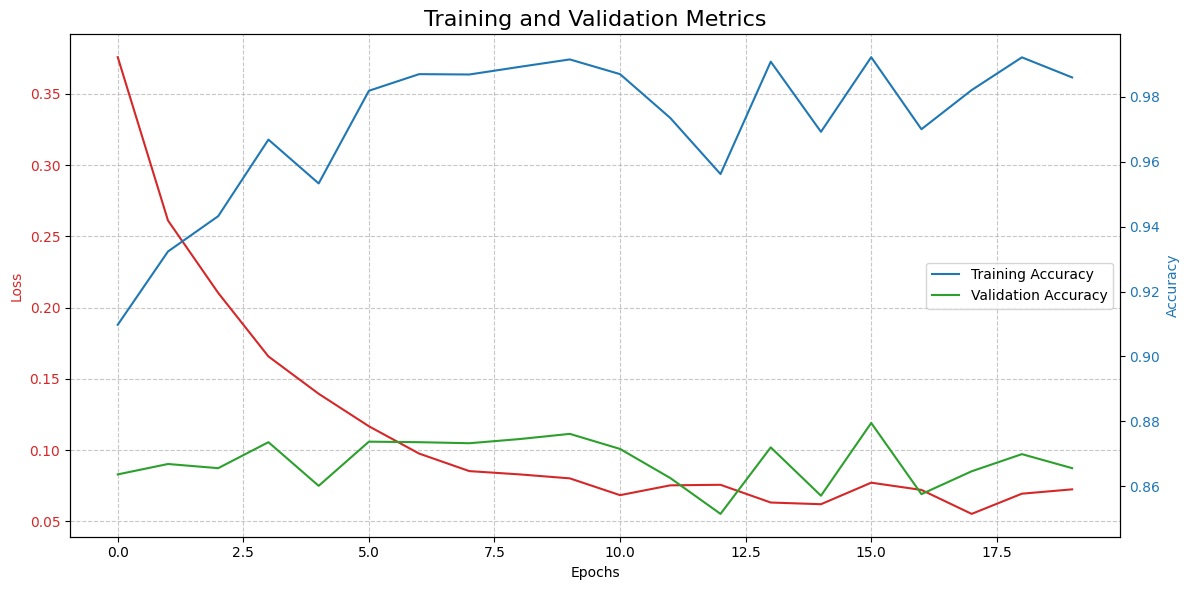

In [38]:
# Loss plot
import matplotlib.pyplot as plt
epochs = range(0,len(epoch_avg_losses))
fig,ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color=color)
ax1.plot(epochs,epoch_avg_losses,color=color)
ax1.tick_params(axis='y',labelcolor=color)


#
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy',color=color)
ax2.plot(epochs,accuracies_train,color=color,label='Training Accuracy')
ax2.plot(epochs,accuracies_dev,color='tab:green',label='Validation Accuracy')
ax2.tick_params(axis='y',labelcolor=color)

# title
plt.title('Training and Validation Metrics',fontsize=16)

lines1,labels1 = ax1.get_legend_handles_labels()
lines2,labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(lines,labels,loc='center right')
ax1.grid(True,linestyle='--',alpha = 0.7)

fig.tight_layout()
plt.show()





# plt.plot(epoch_avg_losses)
# plt.show()

In [39]:
# plot word embedding
model.embeddings.weight.shape # [original_embedding+2,dim] -> [25560,50]

embedding_weights = model.embeddings.weight.detach().cpu().numpy()[:-2] # ignore the two pad  & unk

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_weights)

In [41]:
words_to_plot = [
    # Positive words
    'good', 'excellent', 'amazing', 'wonderful', 'fantastic',
    'great', 'happy', 'joyful', 'love', 'beautiful',
    'brilliant', 'superb', 'perfect',

    # Negative words
    'bad', 'terrible', 'horrible', 'awful', 'dreadful',
    'sad', 'miserable', 'hate', 'ugly', 'evil',
    'nasty', 'cruel',

    # Neutral or ambiguous words
    'exciting', 'thrilling', 'intense',

    # Words with interesting positions in the original plot
    'grim', 'bitter'
]

In [42]:
vocab = list(new_vocabulary.keys())

In [43]:
indices = [new_vocabulary[word] for word in words_to_plot if word in new_vocabulary]
selected_embeddings = reduced_embeddings[indices]
selected_words = [vocab[idx] for idx in indices]


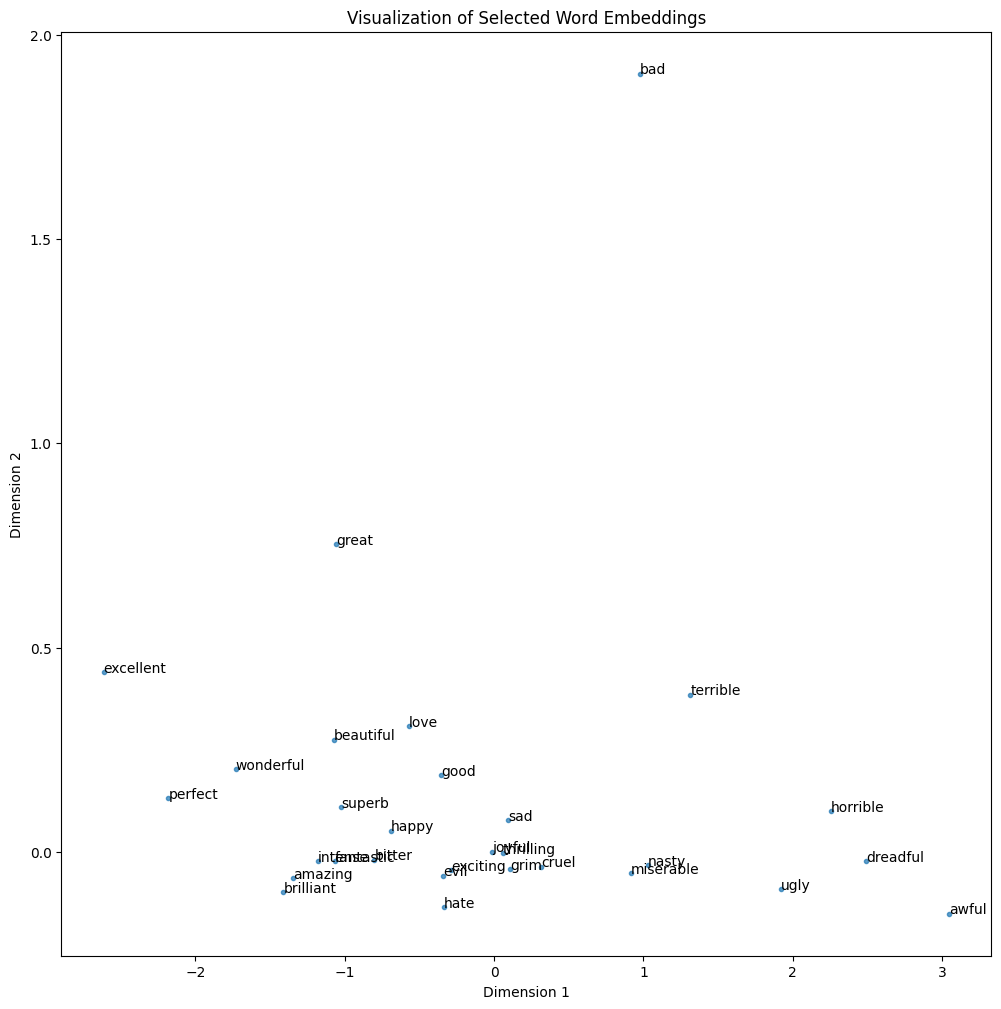

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(selected_embeddings[:, 0], selected_embeddings[:, 1], marker='.', alpha=0.7)

# Annotate the points with the corresponding words
for i, word in enumerate(selected_words):
    plt.annotate(word, (selected_embeddings[i, 0], selected_embeddings[i, 1]))

plt.title('Visualization of Selected Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [45]:
#